In [1]:
from pathlib import Path
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

os.environ["WANDB_SILENT"] = "true"

from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
data_path = "../data/"
"""
Build `X_train_mean, X_val_mean, X_train, X_val, y_train, y_val`
TODO: add other aggregation that mean (e.g. max) ? Use a dict ?
"""

# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path(data_path)

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train_val = pd.read_csv(data_dir / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir / "supplementary_data" / "test_metadata.csv")


# concatenate y_train_val and df_train_val
y_train_val = pd.read_csv(data_dir / "train_output.csv")
df_train_val = df_train_val.merge(y_train_val, on="Sample ID")


In [3]:
# Path for normalization factor
data_norm_path = Path('../data/mean')

center_list = ['C_1', 'C_2', 'C_5']
X_dict = {}
y_dict = {}

# Extract and normalize
for center_curr in center_list:
    X_train = []
    y_train = []

    for sample, label, center, patient in df_train_val[
        ["Sample ID", "Target", "Center ID", "Patient ID"]
    ].values:
        if center == center_curr:
            # load the coordinates and features (1000, 3+2048)
            _features = np.load(train_features_dir / sample)
            # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
            # and the MoCo V2 features
            coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
            X_train.append(features)
            y_train.append(label)

    # convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    # normalize
    norm_factor = np.load(data_norm_path / f'{center}.npy')
    X_train = X_train / norm_factor

    X_dict[center_curr] = X_train
    y_dict[center_curr] = y_train

In [4]:
def hausdorf_matrix_single(bags):
    """Hausdorf distance for a single set of bags."""
    n = bags.shape[0]
    hausdorf = np.zeros((n, n, 3))
    for i in tqdm(range(n)):
        for j in range(i, n):
            dist = np.einsum('ij,ij->i', bags[i], bags[i])[:,None] + np.einsum('ij,ij->i', bags[j], bags[j]) - 2 * np.dot(bags[i], bags[j].T)
            
            min1 = np.min(dist, axis=-1)
            min2 = np.min(dist, axis=0)

            # Vanilla Hausdorf
            dist1 = np.max(min1)
            dist2 = np.max(min2)
            H_max = max(dist1, dist2)

            # Mean Hausdorf
            H_mean = (np.sum(min1) + np.sum(min2)) / (np.size(min1) + np.size(min2)) 

            # Min Hausdorf
            H_min = np.min(min1)

            hausdorf[i, j] = np.array([H_max, H_mean, H_min])
            hausdorf[j, i] = np.array([H_max, H_mean, H_min])
    return hausdorf

def hausdorf_matrix_dual(bags_pred, bags_train):
    """Hausdorf distance between two set of bags."""
    n = bags_pred.shape[0]
    m = bags_train.shape[0]
    hausdorf = np.zeros((n, m, 3))
    for i in tqdm(range(n)):
        for j in range(m):
            dist = np.einsum('ij,ij->i', bags_pred[i], bags_pred[i])[:,None] + np.einsum('ij,ij->i', bags_train[j], bags_train[j]) - 2 * np.dot(bags_pred[i], bags_train[j].T)
            
            min1 = np.min(dist, axis=-1)
            min2 = np.min(dist, axis=0)

            # Vanilla Hausdorf
            dist1 = np.max(min1)
            dist2 = np.max(min2)
            H_max = max(dist1, dist2)

            # Mean Hausdorf
            H_mean = (np.sum(min1) + np.sum(min2)) / (np.size(min1) + np.size(min2)) 

            # Min Hausdorf
            H_min = np.min(min1)

            hausdorf[i, j] = np.array([H_max, H_mean, H_min])
    return hausdorf

In [7]:
for center in center_list:
    X = X_dict[center]
    matrix = hausdorf_matrix_single(X)
    np.save(f'hausdorf_mean_norm_{center}.npy', matrix)

100%|██████████| 114/114 [17:25<00:00,  9.17s/it]


In [5]:
# center1 = 'C_1'
# for center2 in center_list:
#     if center1 != center2:
#         X1 = X_dict[center1]
#         X2 = X_dict[center2]
#         matrix = hausdorf_matrix_dual(X1, X2)
#         np.save(f'hausdorf_mean_norm_{center1}_{center2}.npy', matrix)

center1 = 'C_1'
center2 = 'C_5'
X1 = X_dict[center1]
X2 = X_dict[center2]
matrix = hausdorf_matrix_dual(X1, X2)
np.save(f'hausdorf_mean_norm_{center1}_{center2}.npy', matrix)

center1 = 'C_2'
center2 = 'C_5'
X1 = X_dict[center1]
X2 = X_dict[center2]
matrix = hausdorf_matrix_dual(X1, X2)
np.save(f'hausdorf_mean_norm_{center1}_{center2}.npy', matrix)

100%|██████████| 92/92 [26:17<00:00, 17.14s/it]


In [16]:
def get_matrices(center1, center2, center_test, y_dict, norm=''):

    y1 = y_dict[center1]
    y2 = y_dict[center2]
    y_train = np.concatenate((y1, y2))
    y_test = y_dict[center_test]
    
    n1 = y1.size
    n2 = y2.size
    n_train = n1 + n2
    n_test = y_test.size

    name = 'hausdorf'
    if norm != '':
        name += '_' + norm

    distances_train = np.zeros((n_train, n_train, 3))
    distances_train[:n1, :n1] = np.load(f'{name}_{center1}.npy')
    distances_train[n1:, n1:] = np.load(f'{name}_{center2}.npy')
    distances_train[:n1, n1:] = np.load(f'{name}_{center1}_{center2}.npy')
    distances_train[n1:, :n1] = np.moveaxis(np.load(f'{name}_{center1}_{center2}.npy'), 0, 1)
    distances_train[distances_train < 0] = 0

    distances_pred = np.zeros((n_train, n_test, 3))
    if center1 < center_test:
        distances_pred[:n1] = np.load(f'{name}_{center1}_{center_test}.npy')
    else:
        distances_pred[:n1] = np.moveaxis(np.load(f'{name}_{center_test}_{center1}.npy'), 0, 1)
    
    if center2 < center_test:
        distances_pred[n1:] = np.load(f'{name}_{center2}_{center_test}.npy')
    else:
        distances_pred[n1:] = np.moveaxis(np.load(f'{name}_{center_test}_{center2}.npy'), 0, 1)
    distances_pred[distances_pred < 0] = 0

    return distances_train, y_train, distances_pred, y_test

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

def plot_roc(distances_train, y_train, distances_pred, y_test):
    n_neighbors = np.arange(1, 100)
    fig, axs = plt.subplots(3)
    distance = ['classic', 'mean', 'min']

    for hausdorf_type in range(3):
        roc_auc = np.zeros_like(n_neighbors, dtype=float)
        roc_auc_weight = np.zeros_like(n_neighbors, dtype=float)

        for n_neighbor in n_neighbors: 
            classifier = KNeighborsClassifier(n_neighbors=n_neighbor, metric="precomputed")
            classifier.fit(distances_train[:,:,hausdorf_type], y_train)
            y_pred = classifier.predict_proba(distances_pred[:,:,hausdorf_type].T)
            roc_auc[n_neighbor - 1] = roc_auc_score(y_test, y_pred[:, 1])

            classifier = KNeighborsClassifier(n_neighbors=n_neighbor, metric="precomputed", weights="distance")
            classifier.fit(distances_train[:,:,hausdorf_type], y_train)
            y_pred = classifier.predict_proba(distances_pred[:,:,hausdorf_type].T)
            roc_auc_weight[n_neighbor - 1] = roc_auc_score(y_test, y_pred[:, 1])

        axs[hausdorf_type].set_title(distance[hausdorf_type])
        axs[hausdorf_type].plot(roc_auc, label='number')
        axs[hausdorf_type].plot(roc_auc_weight, label='weight')
        axs[hausdorf_type].legend(loc='best')

        print(f'For {distance[hausdorf_type]}, the roc auc is {roc_auc.max()} with k = {n_neighbors[roc_auc.argmax()]}')
        print(f'For {distance[hausdorf_type]}_weight, the roc auc is {roc_auc_weight.max()} with k = {n_neighbors[roc_auc_weight.argmax()]}')
    plt.show()

# No normalization

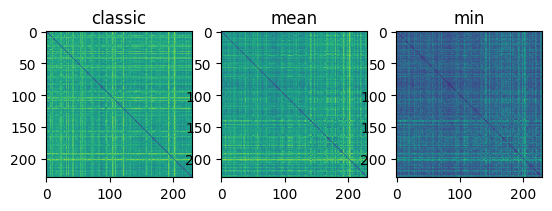

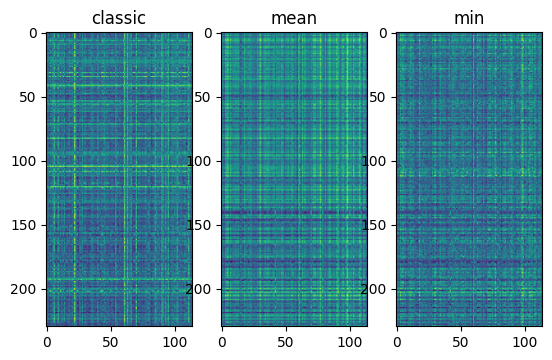

In [18]:
list_cross_val_train = [['C_1', 'C_2'], ['C_1', 'C_5'], ['C_2', 'C_5']]
list_cross_val_test = ['C_5', 'C_2', 'C_1']

center1, center2 = list_cross_val_train[0]
center_test = list_cross_val_test[0]

distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict)

plt.subplot(131)
plt.title('classic')
plt.imshow(distances_train[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(132)
plt.title('mean')
plt.imshow(distances_train[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(133)
plt.title('min')
plt.imshow(distances_train[:,:, 2] / distances_train[:,:, 2].max())
plt.show()

plt.subplot(131)
plt.title('classic')
plt.imshow(distances_pred[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(132)
plt.title('mean')
plt.imshow(distances_pred[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(133)
plt.title('min')
plt.imshow(distances_pred[:,:, 2] / distances_train[:,:, 2].max())
plt.show()

C_1, C_2 as train set and C_5 as test set
For classic, the roc auc is 0.5717710997442456 with k = 94
For classic_weight, the roc auc is 0.5639386189258312 with k = 96
For mean, the roc auc is 0.7089194373401535 with k = 91
For mean_weight, the roc auc is 0.6991687979539642 with k = 88
For min, the roc auc is 0.7373721227621485 with k = 78
For min_weight, the roc auc is 0.7074808184143222 with k = 92


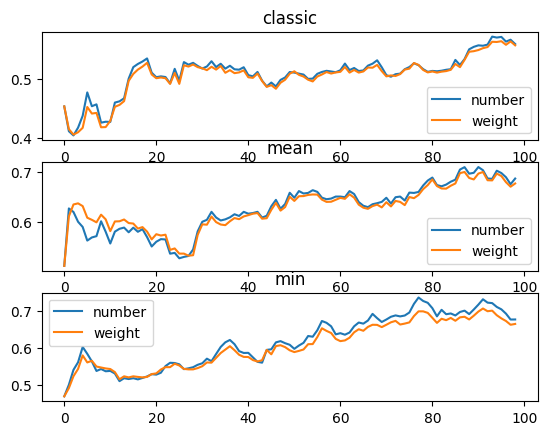

C_1, C_5 as train set and C_2 as test set
For classic, the roc auc is 0.5403184386235234 with k = 20
For classic_weight, the roc auc is 0.5269645608628659 with k = 14
For mean, the roc auc is 0.6471494607087828 with k = 49
For mean_weight, the roc auc is 0.6363636363636364 with k = 49
For min, the roc auc is 0.5790960451977402 with k = 27
For min_weight, the roc auc is 0.5814072932717002 with k = 27


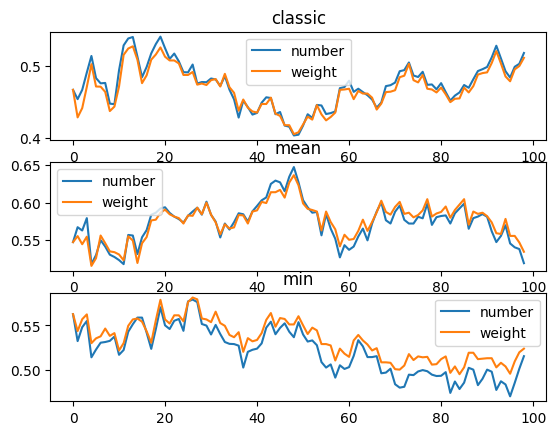

C_2, C_5 as train set and C_1 as test set
For classic, the roc auc is 0.593900481540931 with k = 90
For classic_weight, the roc auc is 0.5757853703279064 with k = 90
For mean, the roc auc is 0.616945654666361 with k = 20
For mean_weight, the roc auc is 0.6248566842467325 with k = 20
For min, the roc auc is 0.5989451960559504 with k = 21
For min_weight, the roc auc is 0.5920660398991057 with k = 23


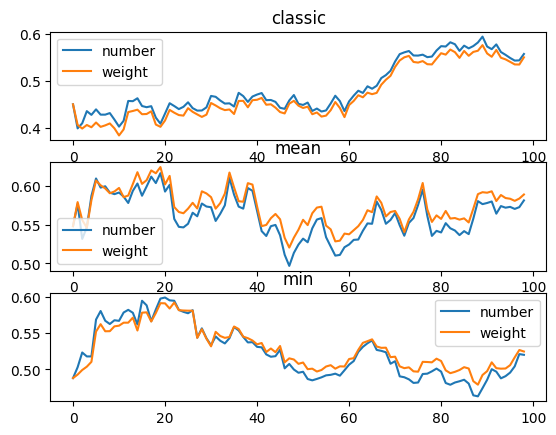

In [19]:
for i in range(len(list_cross_val_train)):
    center1, center2 = list_cross_val_train[i]
    center_test = list_cross_val_test[i]
    print(f'{center1}, {center2} as train set and {center_test} as test set')
    
    distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict)
    plot_roc(distances_train, y_train, distances_pred, y_test)

# Exp norm

In [20]:
list_cross_val_train = [['C_1', 'C_2'], ['C_1', 'C_5'], ['C_2', 'C_5']]
list_cross_val_test = ['C_5', 'C_2', 'C_1']

center1, center2 = list_cross_val_train[0]
center_test = list_cross_val_test[0]

distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict, norm=True)

plt.subplot(131)
plt.title('classic')
plt.imshow(distances_train[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(132)
plt.title('mean')
plt.imshow(distances_train[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(133)
plt.title('min')
plt.imshow(distances_train[:,:, 2] / distances_train[:,:, 2].max())
plt.show()

plt.subplot(131)
plt.title('classic')
plt.imshow(distances_pred[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(132)
plt.title('mean')
plt.imshow(distances_pred[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(133)
plt.title('min')
plt.imshow(distances_pred[:,:, 2] / distances_train[:,:, 2].max())
plt.show()

TypeError: can only concatenate str (not "bool") to str

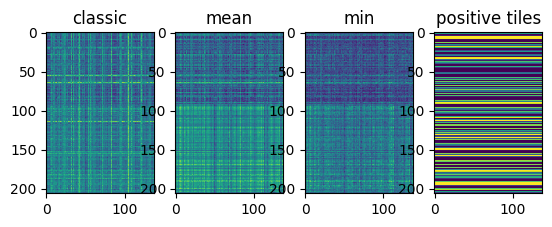

In [21]:
plt.subplot(141)
plt.title('classic')
plt.imshow(distances_pred[:,:, 0] / distances_train[:,:, 0].max())
plt.subplot(142)
plt.title('mean')
plt.imshow(distances_pred[:,:, 1] / distances_train[:,:, 1].max())
plt.subplot(143)
plt.title('min')
plt.imshow(distances_pred[:,:, 2] / distances_train[:,:, 2].max())
plt.subplot(144)
plt.title('positive tiles')
plt.imshow((distances_pred[:, :, 0] * y_train[:, None]) != 0)
plt.show()

C_1, C_2 as train set and C_5 as test set
For classic, the roc auc is 0.6088554987212276 with k = 24
For classic_weight, the roc auc is 0.610613810741688 with k = 24
For mean, the roc auc is 0.6550511508951407 with k = 69
For mean_weight, the roc auc is 0.6707161125319694 with k = 69
For min, the roc auc is 0.6606457800511509 with k = 49
For min_weight, the roc auc is 0.678388746803069 with k = 69


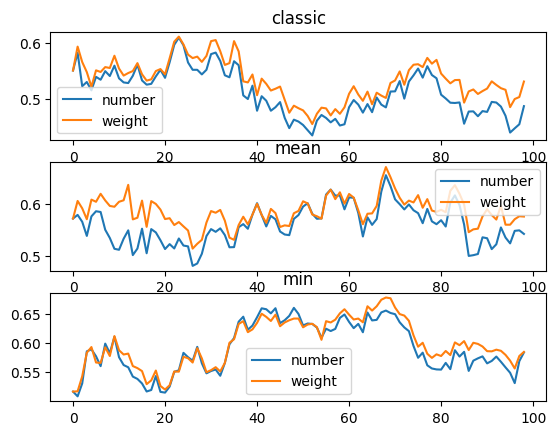

C_1, C_5 as train set and C_2 as test set
For classic, the roc auc is 0.5426296866974833 with k = 33
For classic_weight, the roc auc is 0.5372367745249101 with k = 33
For mean, the roc auc is 0.6484334874165383 with k = 15
For mean_weight, the roc auc is 0.6558808423215203 with k = 14
For min, the roc auc is 0.6458654340010272 with k = 54
For min_weight, the roc auc is 0.6317411402157166 with k = 40


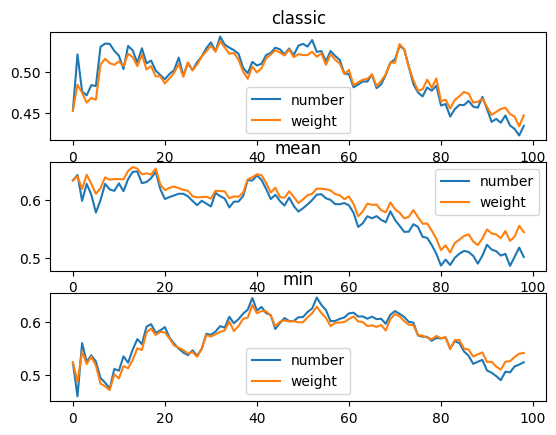

C_2, C_5 as train set and C_1 as test set
For classic, the roc auc is 0.5796835588167851 with k = 26
For classic_weight, the roc auc is 0.580830084842926 with k = 26
For mean, the roc auc is 0.6464113735381792 with k = 17
For mean_weight, the roc auc is 0.6512267828479708 with k = 21
For min, the roc auc is 0.6119009401513414 with k = 6
For min_weight, the roc auc is 0.6094932354964457 with k = 7


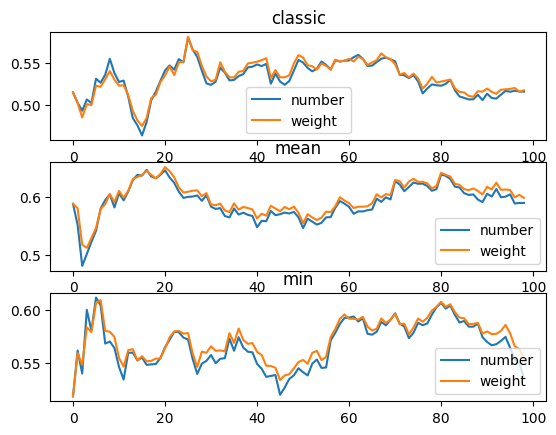

In [23]:
for i in range(len(list_cross_val_train)):
    center1, center2 = list_cross_val_train[i]
    center_test = list_cross_val_test[i]
    print(f'{center1}, {center2} as train set and {center_test} as test set')
    
    distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict, norm='exp_norm')
    plot_roc(distances_train, y_train, distances_pred, y_test)

In [24]:
center1 = 'C_1'
center2 = 'C_2' 
center_test = 'C_5' 

distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict, norm='exp_norm')

n1, n2, _ = distances_pred.shape

distances_matrix = np.zeros((n1 + n2, n1 + n2, 3))
distances_matrix[:n1, :n1] = distances_train
distances_matrix[:n1, n1:] = distances_pred
distances_matrix[n1:, :n1] = np.moveaxis(distances_pred, 0, 1)
distances_matrix[n1:, n1:] = np.load(f'hausdorf_exp_norm_{center_test}.npy')

y = np.zeros(n1 + n2)
y[:n1] = y_train
y[n1:] = y_test

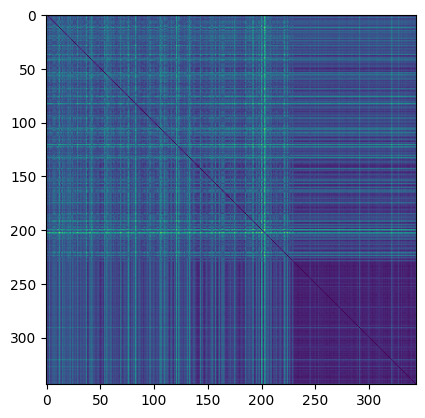

In [25]:
plt.imshow(distances_matrix[:,:,1])

# Mean Norm

C_1, C_2 as train set and C_5 as test set
For classic, the roc auc is 0.6184462915601023 with k = 50
For classic_weight, the roc auc is 0.6486572890025575 with k = 59
For mean, the roc auc is 0.6152493606138107 with k = 45
For mean_weight, the roc auc is 0.6630434782608695 with k = 85
For min, the roc auc is 0.6157289002557546 with k = 6
For min_weight, the roc auc is 0.6262787723785166 with k = 6


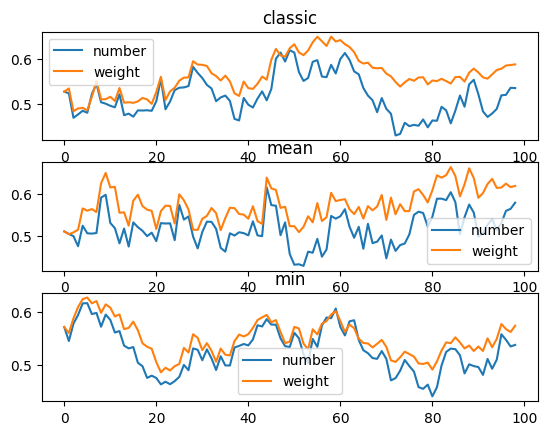

C_1, C_5 as train set and C_2 as test set
For classic, the roc auc is 0.5955315870570108 with k = 98
For classic_weight, the roc auc is 0.5798664612223934 with k = 98
For mean, the roc auc is 0.6361068310220852 with k = 13
For mean_weight, the roc auc is 0.637904468412943 with k = 24
For min, the roc auc is 0.5868002054442732 with k = 4
For min_weight, the roc auc is 0.5693374422187981 with k = 1


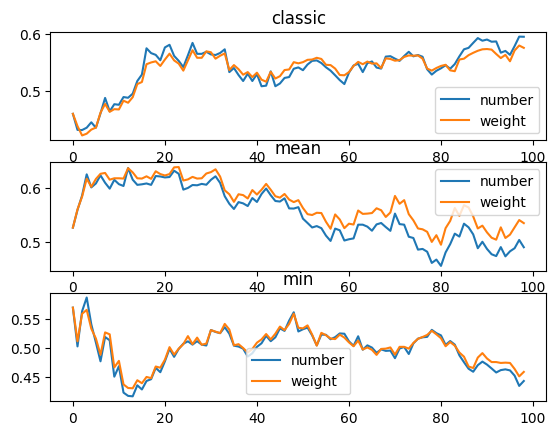

C_2, C_5 as train set and C_1 as test set
For classic, the roc auc is 0.5471222196743867 with k = 36
For classic_weight, the roc auc is 0.5069938087594588 with k = 19
For mean, the roc auc is 0.5941297867461591 with k = 18
For mean_weight, the roc auc is 0.5918367346938775 with k = 19
For min, the roc auc is 0.6304746617748223 with k = 83
For min_weight, the roc auc is 0.6266911258885577 with k = 83


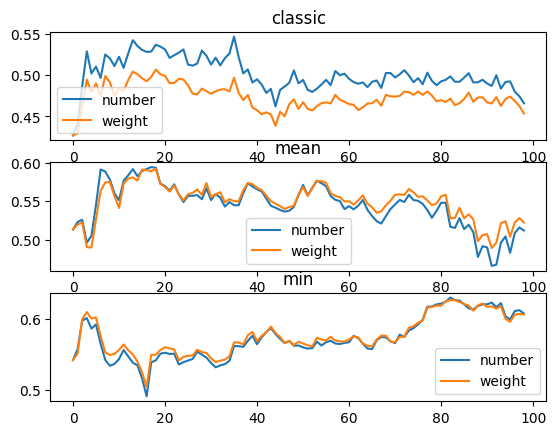

In [26]:
for i in range(len(list_cross_val_train)):
    center1, center2 = list_cross_val_train[i]
    center_test = list_cross_val_test[i]
    print(f'{center1}, {center2} as train set and {center_test} as test set')
    
    distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict, norm='mean_norm')
    plot_roc(distances_train, y_train, distances_pred, y_test)

In [27]:
center1 = 'C_1'
center2 = 'C_2' 
center_test = 'C_5' 

distances_train, y_train, distances_pred, y_test = get_matrices(center1, center2, center_test, y_dict, norm='mean_norm')

n1, n2, _ = distances_pred.shape

distances_matrix = np.zeros((n1 + n2, n1 + n2, 3))
distances_matrix[:n1, :n1] = distances_train
distances_matrix[:n1, n1:] = distances_pred
distances_matrix[n1:, :n1] = np.moveaxis(distances_pred, 0, 1)
distances_matrix[n1:, n1:] = np.load(f'hausdorf_exp_norm_{center_test}.npy')

y = np.zeros(n1 + n2)
y[:n1] = y_train
y[n1:] = y_test

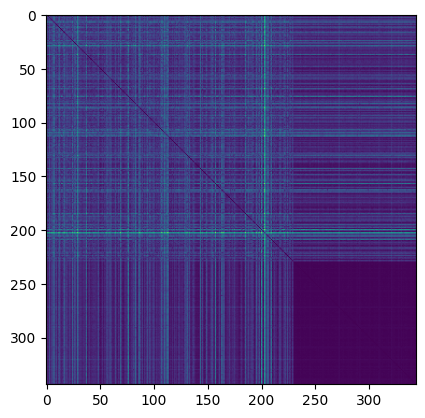

In [31]:
plt.imshow(distances_matrix[:,:,2])

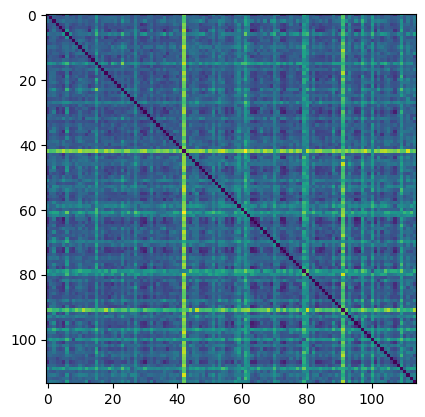

In [30]:
plt.imshow(distances_matrix[n1:,n1:,2])

# Test with graphs

In [18]:
import sknetwork as net
from scipy import sparse

In [75]:
seeds = {}
for i in range(y_train.size):
    seeds[i] = y_train[i]

# Try with all the distances
for i in range(3):
    adjacency = sparse.csr_matrix(distances_matrix[:,:,i])

    # PageRank
    print('PageRank')
    pagerank = net.classification.PageRankClassifier()
    y_pred = pagerank.fit_predict(adjacency, seeds)[n1:]
    print(roc_auc_score(y_test, pagerank.score(1)[n1:]))
    print(net.classification.get_confusion_matrix(y_test, y_pred).toarray())

    # Propagation
    print('Propagation')
    propagation = net.classification.Propagation()
    y_pred = propagation.fit_predict(adjacency, seeds)[n1:]
    print(roc_auc_score(y_test, propagation.score(1)[n1:]))
    print(net.classification.get_confusion_matrix(y_test, y_pred).toarray())

    # Diffusion
    print('Diffusion')
    diffusion = net.classification.DiffusionClassifier()
    y_pred = diffusion.fit_predict(adjacency, seeds)[n1:]
    print(roc_auc_score(y_test, diffusion.score(1)[n1:]))
    print(net.classification.get_confusion_matrix(y_test, y_pred).toarray())
    print()


PageRank
0.4587595907928389
[[54 14]
 [42  4]]
Propagation
0.5332480818414322
[[68  0]
 [46  0]]
Diffusion
0.45684143222506396
[[68  0]
 [46  0]]

PageRank
0.32512787723785164
[[28 40]
 [28 18]]
Propagation
0.48785166240409206
[[68  0]
 [46  0]]
Diffusion
0.309462915601023
[[68  0]
 [46  0]]

PageRank
0.3836317135549872
[[12 56]
 [12 34]]
Propagation
0.5226982097186701
[[68  0]
 [46  0]]
Diffusion
0.39833759590792844
[[ 3 65]
 [ 3 43]]



In [73]:
seeds = {}
for i in range(y_train.size):
    seeds[i] = y_train[i]

k_list = np.arange(2, 50, 5)
roc = np.zeros((k_list.size, 3))

for i, k in enumerate(k_list):
    print(k, end=' ')
    knn = net.utils.KNNDense(n_neighbors=k)
    adjacency_k = knn.fit_transform(adjacency.toarray())

    # PageRank
    pagerank = net.classification.PageRankClassifier()
    y_pred = pagerank.fit_predict(adjacency_k, seeds)[n1:]
    roc[i, 0] = roc_auc_score(y_test, pagerank.score(1)[n1:])

    # Propagation
    propagation = net.classification.Propagation()
    y_pred = propagation.fit_predict(adjacency_k, seeds)[n1:]
    roc[i, 1] = roc_auc_score(y_test, propagation.score(1)[n1:])

    # Diffusion
    diffusion = net.classification.DiffusionClassifier()
    y_pred = diffusion.fit_predict(adjacency_k, seeds)[n1:]
    roc[i, 2] = roc_auc_score(y_test, diffusion.score(1)[n1:])


2 7 12 17 22 27 32 37 42 47 

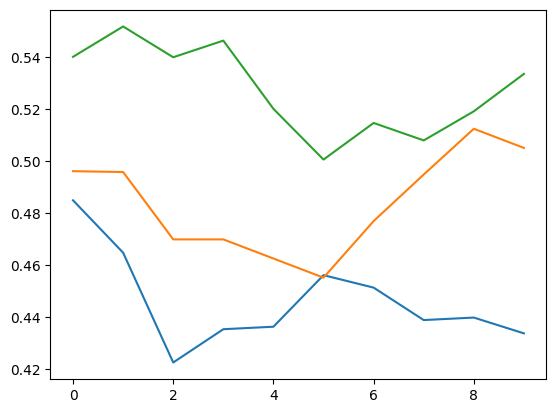

In [74]:
plt.plot(roc)